# Create Figures for ASPECT Model
This notebook uses the ages calculated in `process_model.ipynb` for the sample ASPECT uplift model to create publication-ready figures.

In [1]:
# Imports
import os
import shutil

import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd
import pyvista as pv

import cmcrameri.cm as cmc

from tqdm import tqdm

import gdtchron as gdt

The cell below plots the temperature structure and boundary velocity conditions for the model.

98000


/tmp/ipykernel_2993/2983081138.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


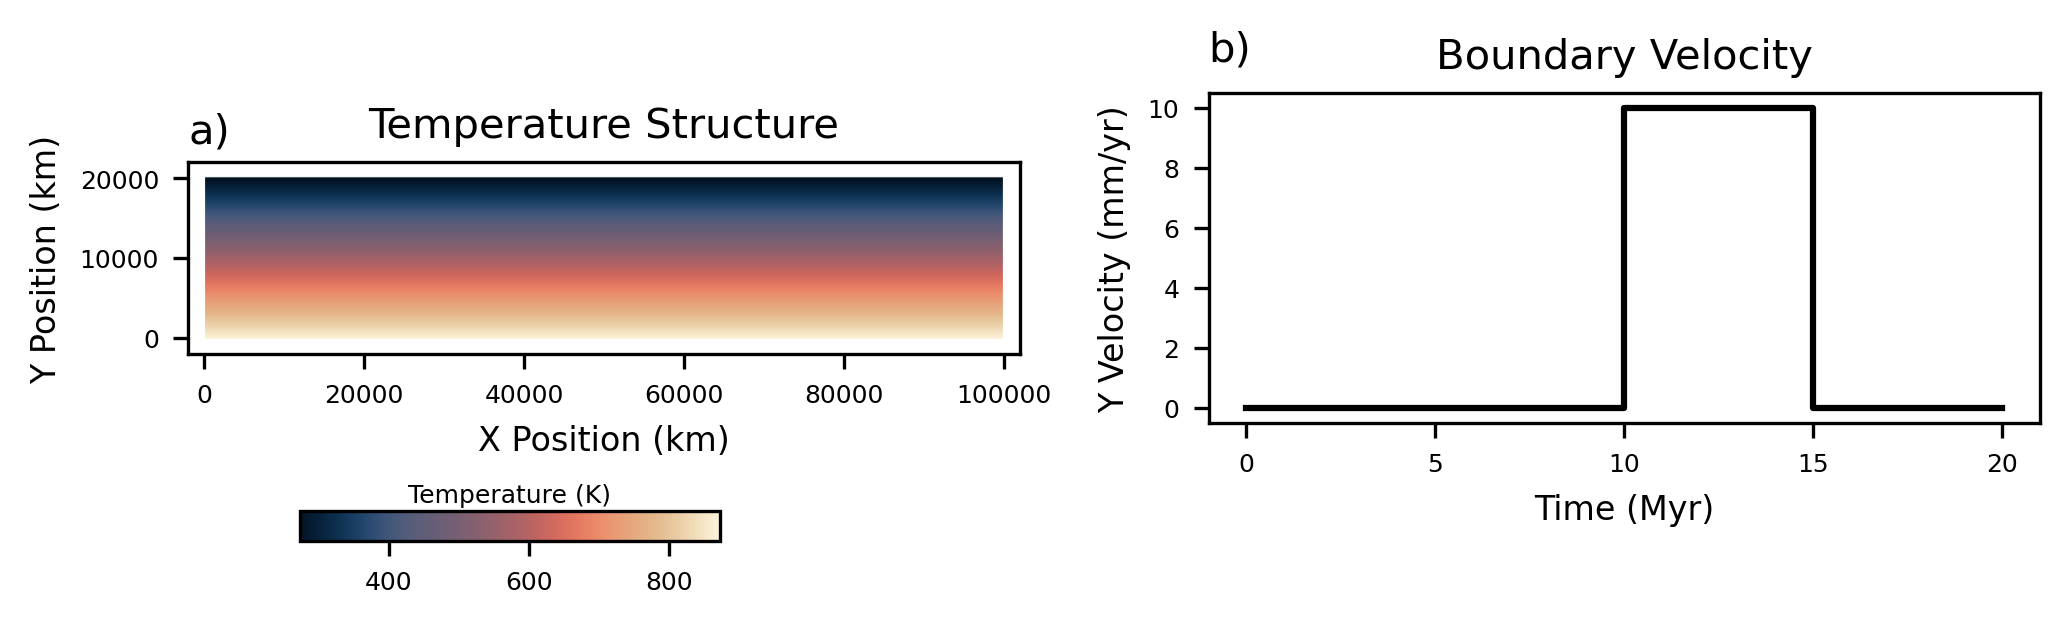

In [4]:
# Model setup figure
fig,axs = plt.subplots(1,2,dpi=300,figsize=(7,2))
file = 'meshes_tchron/meshes_tchron_000.vtu'
mesh = pv.read(file)

clim = (273,873)
cmap = cmc.lipari

gdt.plot_vtk_2d(mesh,'T',bounds=[-2e3,102e3,-2e3,22e3],ax=axs[0],
          cmap=cmap,colorbar=False,clim=clim)

axs[0].set_title('Temperature Structure',fontsize=10)
axs[0].set_xlabel('X Position (km)',fontsize=8)
axs[0].set_ylabel('Y Position (km)',fontsize=8)

times = [0,10,10,15,15,20]
y_vel = [0,0,10,10,0,0]
axs[1].plot(times,y_vel,c='black')
axs[1].set_title('Boundary Velocity',fontsize=10)
axs[1].set_xlabel('Time (Myr)',fontsize=8)
axs[1].set_ylabel('Y Velocity (mm/yr)',fontsize=8)
axs[1].set_xticks([0,5,10,15,20])

for k,ax in enumerate(axs):
    ax.tick_params(labelsize=6)
    ax.annotate(chr(97+k) + ')',(0,1.1),xycoords='axes fraction',fontsize=10)

cax = fig.add_axes([0.15,0.05,0.2,0.05])
norm = mcolors.Normalize(vmin=clim[0],vmax=clim[1])
sm = cm.ScalarMappable(cmap=cmap,norm=norm)
plt.colorbar(sm,cax=cax,orientation='horizontal')

cax.tick_params(labelsize=6)
cax.set_title('Temperature (K)',fontsize=6,pad=2)

plt.tight_layout()
fig.savefig('uplift_setup.jpg',bbox_inches='tight')


The cell below defines some parameters for the plot of the model results

In [5]:
# Set up parameters
bounds = [35e3,65e3,8e3,20e3] # m
times = [10,15,20] # Myr
labels = ['Before Uplift','After Uplift','After Quiescence']

ahe_cmap = cmc.lapaz_r
aft_cmap = cmc.lajolla_r
zhe_cmap = cmc.bamako_r
cat_cmap = cmc.batlowS

clim = [0,20] # Myr
bar=False

The cell below plots a results figure showing each thermochronologic system at 10 Myr, 15 Myr, and 20 Myr. These are plotted both as views of part of the box itself and as vertical profiles through the box. It also includes relatively fine adjustements to plot layout, colorbars, lables, etc.

KeyError: 'Data array (AFT) not present in this dataset.'

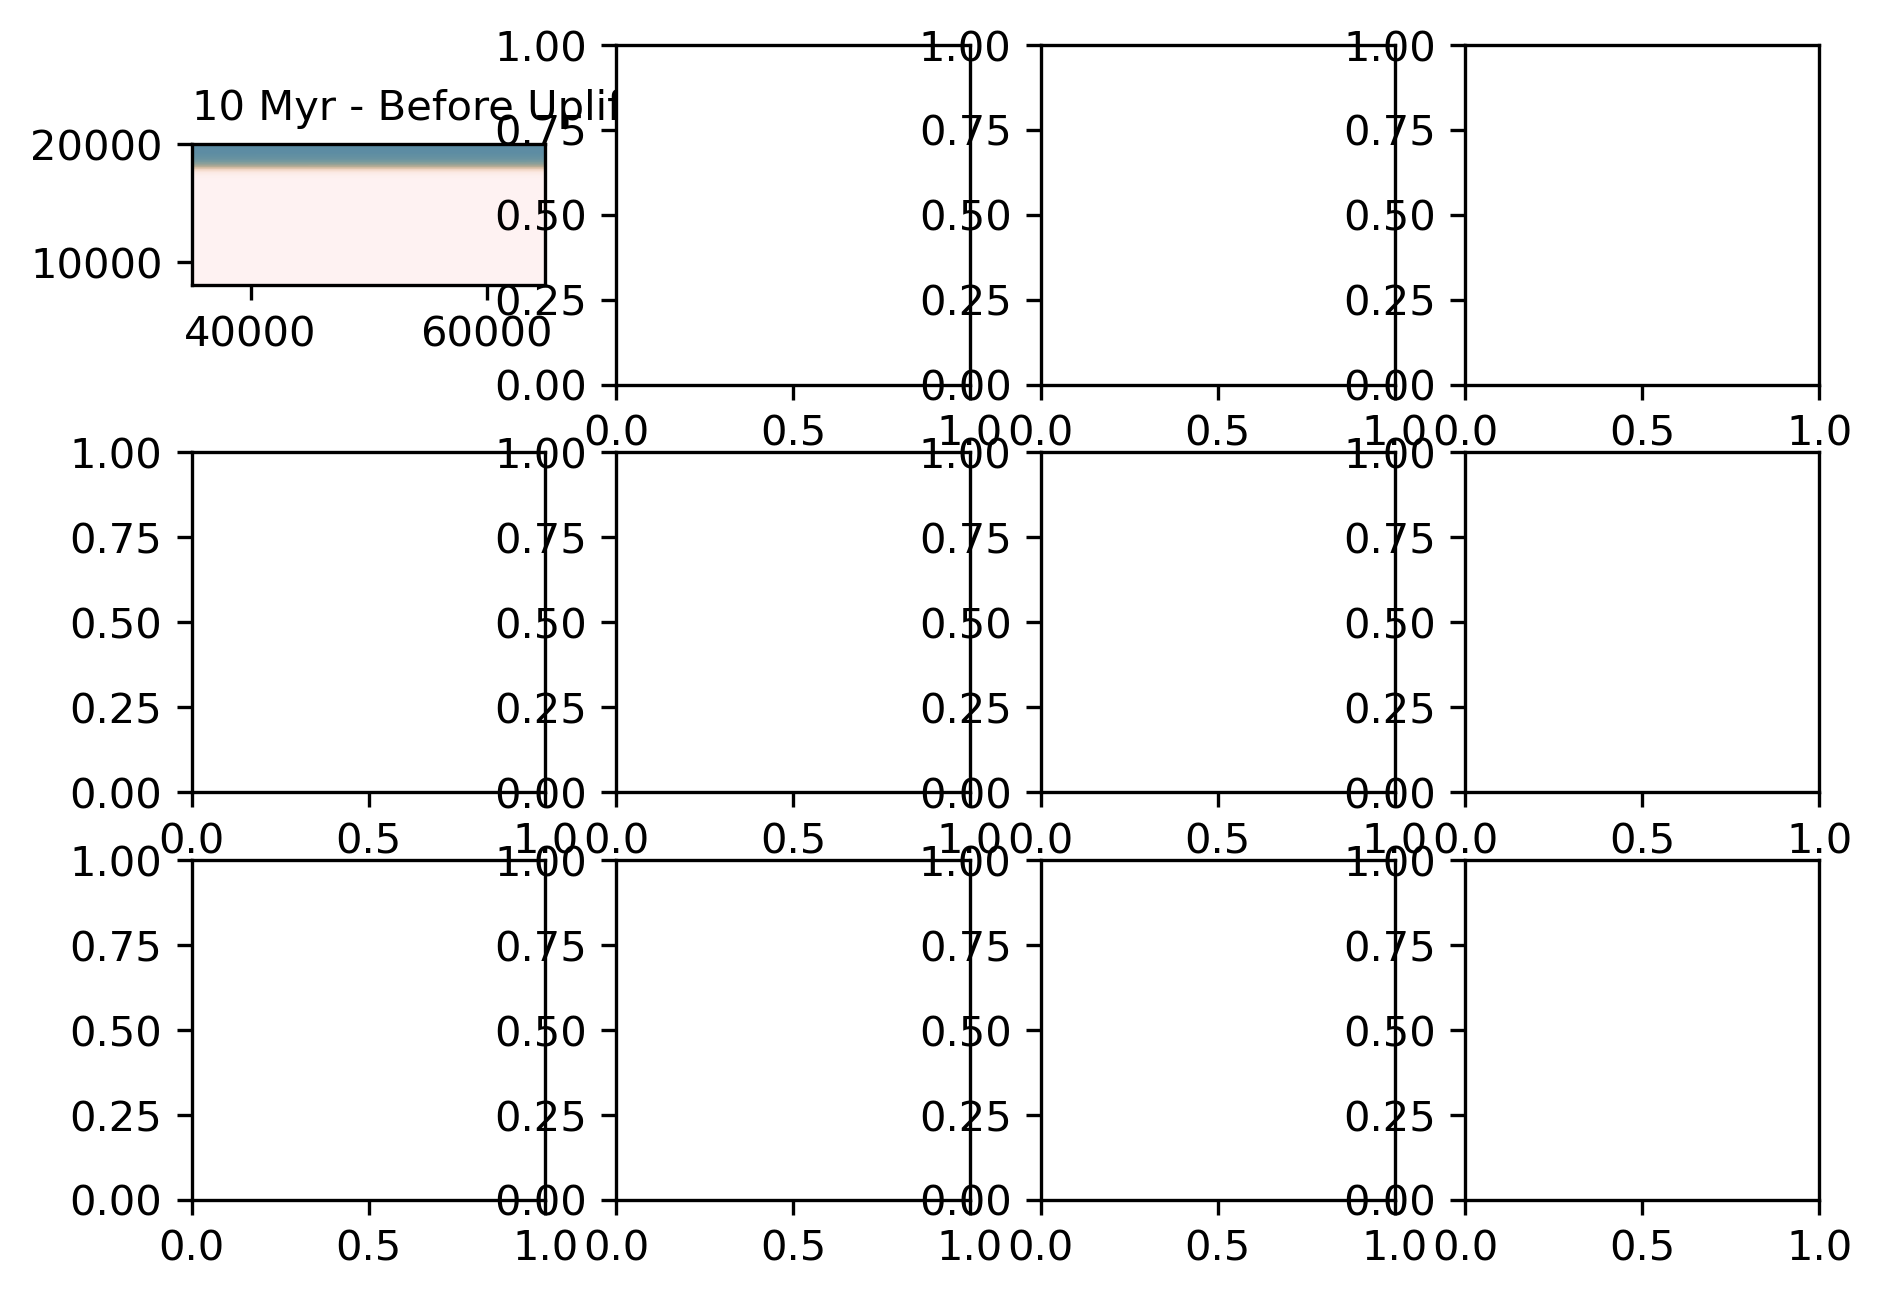

In [7]:
# Results figure
fig,axs = plt.subplots(3,4,dpi=300,figsize=(7,5))

for k,time in enumerate(times):

    file_num = str(time*10).zfill(3)
    file = 'meshes_tchron/meshes_tchron_' + file_num + '.vtu'
    mesh = pv.read(file)
    
    axs[k,0].set_title(str(round(time,0)) +' Myr - ' + labels[k],loc='left',fontsize=10)

    file_dir='meshes_tchron'
    file_num = str(time)
    
    gdt.plot_vtk_2d(mesh,'AHe',bounds=bounds,ax=axs[k,0],
              cmap=ahe_cmap,colorbar=bar,clim=clim)
    
    gdt.plot_vtk_2d(mesh,'AFT',bounds=bounds,ax=axs[k,1],
            cmap=aft_cmap,colorbar=bar,clim=clim)
    
    gdt.plot_vtk_2d(mesh,'ZHe',bounds=bounds,ax=axs[k,2],
        cmap=zhe_cmap,colorbar=bar,clim=clim)

    y = np.round(mesh.points[:,1]/1000,0)
    AHe = mesh['AHe']
    AFT = mesh['AFT']
    ZHe = mesh['ZHe']

    df = pd.DataFrame({'y':y,'AHe':AHe,'AFT':AFT,'ZHe':ZHe})
    df_max = df.groupby('y').agg({'y':'first','AHe':'max','AFT':'max','ZHe':'max'})

    axs[k,3].plot(df_max['AHe'],df_max['y'],c=cat_cmap.colors[6],label='AHe')
    axs[k,3].plot(df_max['AFT'],df_max['y'],c=cat_cmap.colors[4],label='AFT')
    axs[k,3].plot(df_max['ZHe'],df_max['y'],c=cat_cmap.colors[2],label='ZHe')

    axs[k,3].set_xlim(-0.25,20)
    axs[k,3].set_ylim(bounds[2],bounds[3])
    axs[k,3].text(0.3,-.03,
                'Surface Ages\n'
                  + 'AHe: ' + str(round(df_max['AHe'][20],1)) + ' Ma\n'
                  + 'AFT: ' + str(round(df_max['AFT'][20],1)) + ' Ma\n'
                  + 'ZHe: '+ str(round(df_max['ZHe'][20],1)) + ' Ma\n',
                transform=axs[k,3].transAxes,fontsize=7)

cax_ahe = fig.add_axes([0.08,0.68,0.15,0.02])
cax_aft = fig.add_axes([0.32,0.68,0.15,0.02])
cax_zhe = fig.add_axes([0.56,0.68,0.15,0.02])

norm = mcolors.Normalize(vmin=clim[0],vmax=clim[1])

sm_ahe = cm.ScalarMappable(cmap=ahe_cmap,norm=norm)
sm_aft = cm.ScalarMappable(cmap=aft_cmap,norm=norm)
sm_zhe = cm.ScalarMappable(cmap=zhe_cmap,norm=norm)

for cax in [cax_ahe,cax_aft,cax_zhe]:
    cax.tick_params(labelsize=6)
    plt.colorbar(sm,cax=cax,orientation='horizontal')

cax_ahe.set_title('AHe Age (Ma)',fontsize=6)
cax_aft.set_title('AFT Age (Ma)',fontsize=6)
cax_zhe.set_title('ZHe Age (Ma)',fontsize=6)

axs[0,0].set_ylabel('Y Position (km)',fontsize=6)
axs[1,0].set_ylabel('Y Position (km)',fontsize=6)
axs[2,0].set_ylabel('Y Position (km)',fontsize=6)

axs[2,0].set_xlabel('X Position (km)',fontsize=6)
axs[2,1].set_xlabel('X Position (km)',fontsize=6)
axs[2,2].set_xlabel('X Position (km)',fontsize=6)
axs[2,3].set_xlabel('Maximum Age (Ma)',fontsize=6)

axs[0,3].set_ylabel('Y Position (km)',fontsize=6)
axs[1,3].set_ylabel('Y Position (km)',fontsize=6)
axs[2,3].set_ylabel('Y Position (km)',fontsize=6)

axs[0,3].legend(fontsize=6)

for ax in axs.flat:
    ax.tick_params(labelsize=6)

plt.tight_layout()
fig.savefig('uplift_results.jpg')